In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
base = pd.read_csv('/workspaces/learning-machine-learning/udemy/a_z/bolsa_valores/petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:2].values
base_valor_maximo = base.iloc[:, 2:3].values

In [4]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [5]:
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo)

In [7]:
previsores = []
preco_real1 = []
preco_real2 = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_valor_maximo_normalizada[i, 0])
    preco_real2.append(base_valor_maximo_normalizada[i, 0])

previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [8]:
preco_real = np.column_stack((preco_real1, preco_real2))

In [9]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=2, activation='linear'))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
regressor.fit(previsores, preco_real, epochs=100, batch_size=32)

In [11]:
base_teste = pd.read_csv('/workspaces/learning-machine-learning/udemy/a_z/bolsa_valores/petr4_teste.csv')
preco_real_open = base_teste.iloc[:, 1:2].values
preco_real_high = base_teste.iloc[:, 2:3].values

In [12]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

In [13]:
x_teste = []
for i in range(90, 112):
    x_teste.append(entradas[i-90:i, 0])
x_teste = np.array(x_teste)
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))

In [14]:
previsoes = regressor.predict(x_teste)
previsoes = normalizador.inverse_transform(previsoes)
previsoes[:, 0]

1/1 [==============================] - 1s 1s/step


array([16.298653, 16.386702, 16.478643, 16.611963, 16.7582  , 16.883934,
       17.00401 , 17.100208, 17.154127, 17.186245, 17.244349, 17.334541,
       17.504318, 17.778929, 18.090534, 18.350632, 18.529001, 18.626312,
       18.772818, 19.020817, 19.320978, 19.604507], dtype=float32)

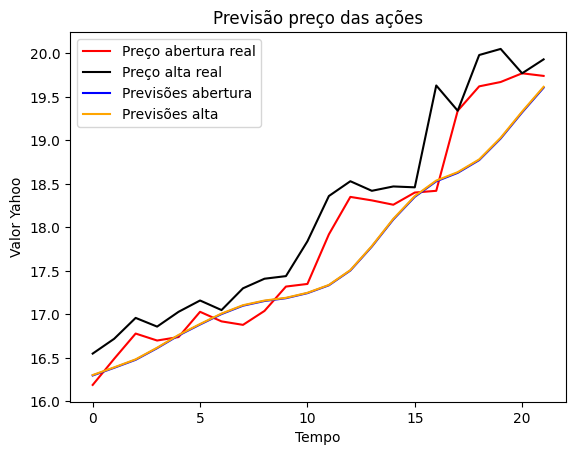

In [15]:
plt.plot(preco_real_open, color='red', label='Preço abertura real')
plt.plot(preco_real_high, color='black', label='Preço alta real')

plt.plot(previsoes[:, 0], color='blue', label='Previsões abertura')
plt.plot(previsoes[:, 1], color='orange', label='Previsões alta')

plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()